In [1]:
import numpy as np
from keras.models import Sequential
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Activation, Input, concatenate, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import Adamax
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import tensorflow as tf
import random

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
NUMBER_OF_CLASSES = 10
epochs = 200
batch_size = 100
IMAGE_ROW = 32
IMAGE_COL = 32
IMAGE_DEPTH = 3
path_best = "gdrive/My Drive/Colab Notebooks/Adverserial_2.h5"
path_train = "gdrive/My Drive/Colab Notebooks/Adverserial_2.h5" 

In [4]:
(x_train,y_train), (x_test, y_test) = cifar10.load_data()

y_train_norm = to_categorical(y_train, NUMBER_OF_CLASSES)
y_test_norm = to_categorical(y_test, NUMBER_OF_CLASSES)

y_test = y_test.flatten()

x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

mean = np.mean(x_train, axis=(0,1,2,3))
std = np.std(x_train, axis=(0,1,2,3))

x_train_norm = (x_train-mean)/(std+1e-7)
x_test_norm = (x_test-mean)/(std+1e-7)

In [5]:
# datagen = ImageDataGenerator(
#     featurewise_center=False,
#     samplewise_center=False,
#     featurewise_std_normalization=False,
#     samplewise_std_normalization=False,
#     zca_whitening=False,
#     zca_epsilon=1e-06,
#     rotation_range=10,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=True,
#     vertical_flip=False)

# datagen.fit(x_train_norm)

In [6]:
def inceptionBuilder(l, f_1x1, f_3x3_r, f_3x3, f_5x5_r, f_5x5, f_p):
    l_1 = Conv2D(filters=f_1x1, kernel_size=(1,1), padding='same', activation='relu')(l)

    l_3 = Conv2D(filters=f_3x3_r, kernel_size=(1,1), padding='same', activation='relu')(l)
    l_3 = Conv2D(filters=f_3x3, kernel_size=(3,3), padding='same', activation='relu')(l_3)

    l_5 = Conv2D(filters=f_5x5_r, kernel_size=(1,1), padding='same', activation='relu')(l)
    l_5 = Conv2D(filters=f_5x5, kernel_size=(5,5), padding='same', activation='relu')(l_5)

    l_p = MaxPool2D(pool_size=(3,3), strides=(1,1), padding='same')(l)
    l_p = Conv2D(filters=f_p, kernel_size=(1,1), padding='same', activation='relu')(l_p)
 
    ret = concatenate([l_1, l_3, l_5, l_p], axis=3)

    return ret

In [7]:
def create_InceptionV2Model():
    input = Input(shape=(32,32,3))
    l = Conv2D(filters=64, kernel_size=(7,7), padding="same")(input)
    l = Activation('relu')(l)
    
    l = MaxPool2D(pool_size=(3,3), padding='same', strides=(2,2))(l)
    l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
    l = Conv2D(filters=192, kernel_size=(3,3), activation='relu')(l)
    l = MaxPool2D(pool_size=(3,3), padding='same', strides=(2,2))(l)

    l = inceptionBuilder(l, 64, 96, 128, 16, 32, 32)
    l = inceptionBuilder(l, 128, 128, 192, 32, 96, 64)

    l = MaxPool2D(pool_size=(3,3,), strides=(2,2), padding='same')(l)

    l = inceptionBuilder(l, 192, 96, 208, 16, 48, 64)

    l = GlobalAveragePooling2D()(l)
    l = Dense(NUMBER_OF_CLASSES, activation='softmax')(l)

    model = Model(inputs = input, outputs = l)
    return model

In [8]:
model = create_InceptionV2Model()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 64)   0           activation[0][0]                 
_______________________________________________________________________________________

In [9]:
model.compile(optimizer=Adamax(learning_rate=0.0001, decay=1e-06), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [10]:
def adversarial_pattern(image, label):
    image = tf.cast(image, tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.MSE(label, prediction)
    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)
    return signed_grad

In [11]:
def generate_adversarials(sample_size):
    while True:
        x = []
        y = []
        for batch in range(sample_size):
            N = random.randint(0, 50000-1)
            label = y_train[N]
            image = x_train[N]
            perturbations = adversarial_pattern(image.reshape((1, IMAGE_ROW, IMAGE_COL, IMAGE_DEPTH)), label).numpy()
            epsilon = 0.005
            adversarial = image + perturbations * epsilon
            x.append(adversarial)
            y.append(y_train[N])
        x = np.asarray(x).reshape((sample_size, IMAGE_ROW, IMAGE_COL, IMAGE_DEPTH))
        y = np.asarray(y)
        yield x, y

In [12]:
x_adversarial_train, y_adversarial_train = next(generate_adversarials(40000))
y_adversarial_train = to_categorical(y_adversarial_train, NUMBER_OF_CLASSES)

In [13]:
x_train_total = np.vstack((x_train_norm, x_adversarial_train))
y_train_total = np.vstack((y_train_norm, y_adversarial_train))

In [14]:
checkpoint = ModelCheckpoint(path_train, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=100, verbose=1, mode='auto')

In [15]:
history = model.fit(x_train_total, y_train_total,
                        batch_size=batch_size,
                        steps_per_epoch=x_adversarial_train.shape[0]// batch_size,
                        epochs=epochs,
                        validation_data=(x_test_norm, y_test_norm),
                        callbacks=[checkpoint],verbose=2)

Epoch 1/200

Epoch 00001: val_accuracy improved from -inf to 0.33590, saving model to gdrive/My Drive/Colab Notebooks/Adverserial_2.h5
400/400 - 9s - loss: 2.0549 - accuracy: 0.2294 - val_loss: 1.8245 - val_accuracy: 0.3359
Epoch 2/200

Epoch 00002: val_accuracy improved from 0.33590 to 0.36750, saving model to gdrive/My Drive/Colab Notebooks/Adverserial_2.h5
400/400 - 8s - loss: 1.8406 - accuracy: 0.3204 - val_loss: 1.7228 - val_accuracy: 0.3675
Epoch 3/200

Epoch 00003: val_accuracy improved from 0.36750 to 0.39590, saving model to gdrive/My Drive/Colab Notebooks/Adverserial_2.h5
400/400 - 9s - loss: 1.7278 - accuracy: 0.3726 - val_loss: 1.6336 - val_accuracy: 0.3959
Epoch 4/200

Epoch 00004: val_accuracy improved from 0.39590 to 0.41350, saving model to gdrive/My Drive/Colab Notebooks/Adverserial_2.h5
400/400 - 9s - loss: 1.6547 - accuracy: 0.4040 - val_loss: 1.6019 - val_accuracy: 0.4135
Epoch 5/200

Epoch 00005: val_accuracy improved from 0.41350 to 0.45800, saving model to gdrive

**Training**

*Plotting training accuracy and loss*

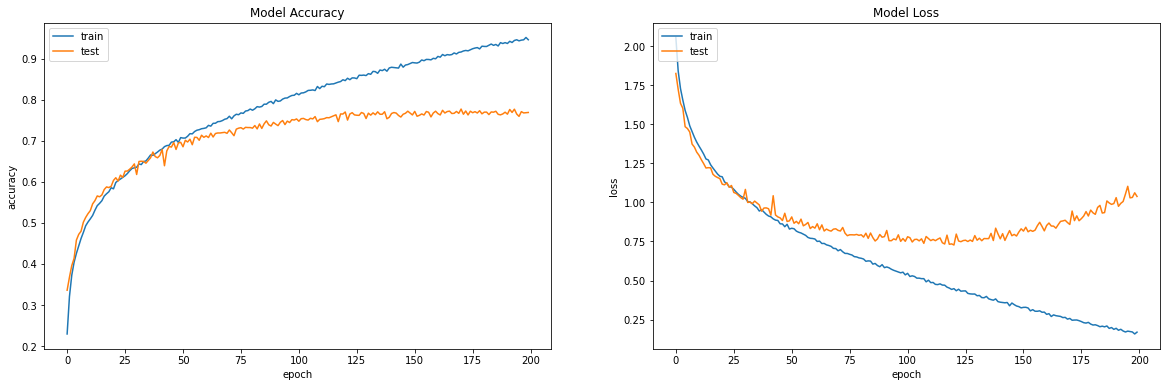

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set(ylabel ='accuracy')
axs[0].set(xlabel ='epoch')
axs[0].legend(['train', 'test'], loc='upper left')

axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set(ylabel='loss')
axs[1].set(xlabel='epoch')
axs[1].legend(['train', 'test'], loc='upper left')

**Prediction**

In [17]:
model.load_weights(path_best)
y_pred = np.argmax(model.predict(x_test_norm), axis=-1)

In [18]:
precision = precision_score(y_test, y_pred, average='weighted')
print("Precision: ", precision)
recall = recall_score(y_test, y_pred, average='weighted')
print("Recall: ", recall)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Precision:  0.7778714401172486
Recall:  0.777
Accuracy:  0.777
